## Creating Birdman plots HCC Data
Date: 11/21/2023  
Taken from: https://github.com/ahdilmore/MARS_Birdman/blob/main/birdman/zebra_birdman_analysis.ipynb
  
conda env: comad

#### Imports

In [1]:
import pandas as pd
import qiime2 as q2
import numpy as np
import biom

# plotting 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
'''
data_dict = {
    #'tumor_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1': 'tumor_HCC_v_CRC/inferences-results/tumor_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1.beta_var.tsv',
    'CRC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1': 'CRC_adj_v_tumor/inferences-results/CRC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1.beta_var.tsv',
    #'HCC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1': 'HCC_adj_v_tumor/inferences-results/HCC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1.beta_var.tsv',
    #'adj_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1': 'adj_HCC_v_CRC/inferences-results/adj_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1.beta_var.tsv',
    'blood_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1': 'blood_HCC_v_CRC/inferences-results/blood_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1.beta_var.tsv',
}
vars_to_check = {
    #'tumor_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1' : 'tumor_type[T.HCC]_',
    'CRC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1' : 'host_sample_type[T.tumor]_',
    #'HCC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1' : 'host_sample_type[T.tumor]_'
    #'adj_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1' : 'tumor_type[T.HCC]_'
    'blood_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1' : 'tumor_type[T.HCC]_'
}
'''

In [18]:
data_dict = {
    'CRC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1': 'CRC_adj_v_tumor/inferences-results/CRC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1.beta_var.tsv',
}
vars_to_check = {
    'CRC_adj_v_tumor_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1' : 'host_sample_type[T.tumor]_',
}

In [22]:
data_dict = {
    'blood_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1': 'blood_HCC_v_CRC/inferences-results/blood_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1.beta_var.tsv',
}
vars_to_check = {
    'blood_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1' : 'tumor_type[T.HCC]_'
}

#### Functions

In [3]:
def read_results(p):
    return pd.read_csv(p, sep='\t', index_col='Feature')

def unpack_hdi_and_filter(df, col):
    df[['lower', 'upper']] = df[col].str.split(',', expand=True)
    # remove ( from lower and ) from upper and convert to float 
    df.lower = df.lower.str[1:].astype('float')
    df.upper = df.upper.str[:-1].astype('float')
    
    df['credible'] = np.where((df.lower > 0) | (df.upper < 0), 'yes', 'no')
    
    df.upper = df.upper - df[col.replace('hdi', 'mean')]
    df.lower = df[col.replace('hdi', 'mean')] - df.lower
    
    return df

In [4]:
# check if there are more than 20 features --> if so, only display top and bottom 10 
# otherwise display all 

def display_top_n_feats(df, n, yvar, xvar, xlab, ylab, title):
    if df.shape[0] < 2*n: 
        df_for_display = df 
    else: 
        bottomn = df[:n]
        topn = df[-1*n:]
        df_for_display = pd.concat([bottomn, topn])
    
    sns.stripplot(data=df_for_display, y=yvar, x=xvar)
    plt.errorbar(data=df_for_display, 
                 x=xvar, y=yvar,
                 xerr=df_for_display[['lower', 'upper']].T, ls='none')
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.show()

In [5]:
#Create Wol2 taxanomy into a useable dic
wol2 = pd.read_csv('/projects/wol/qiyun/wol2/taxonomy/lineages.txt', sep='\t', header=None, index_col=0)
wol2_dict = wol2[1].to_dict() 

def add_taxonomy_col(df):
    
    # Convert gOTUS into readable taxonomy
    df['Taxonomy'] = df['Feature'].map(wol2_dict)
    
    #Create label with gOTU and taxonomu
    df['gOTU_Taxonomy'] = df['Feature'] + ' : ' + df['Taxonomy']

#### Code

In [23]:
# update names 
for k in data_dict.keys():
    df = read_results(data_dict[k])
    for v in vars_to_check: 
        if v in k: 
            var = vars_to_check[v] 
    print(k)
    print('Unfiltered Shape:  ' + str(df.shape))
    sub_df = unpack_hdi_and_filter(df, var+'hdi')
    print('Filtered Shape: ' + str(sub_df.loc[sub_df['credible'] == 'yes'].shape))
    sub_df.rename_axis(index='Feature', inplace=True)
    
    data_dict[k] = sub_df.sort_values(by=var+'mean')

blood_HCC_v_CRC_qiita15336_prep16181_pangenome_wol2_scrubbed_zebraFilter0.1
Unfiltered Shape:  (378, 6)
Filtered Shape: (63, 9)


#### Plotting

tumor_type[T.HCC]_


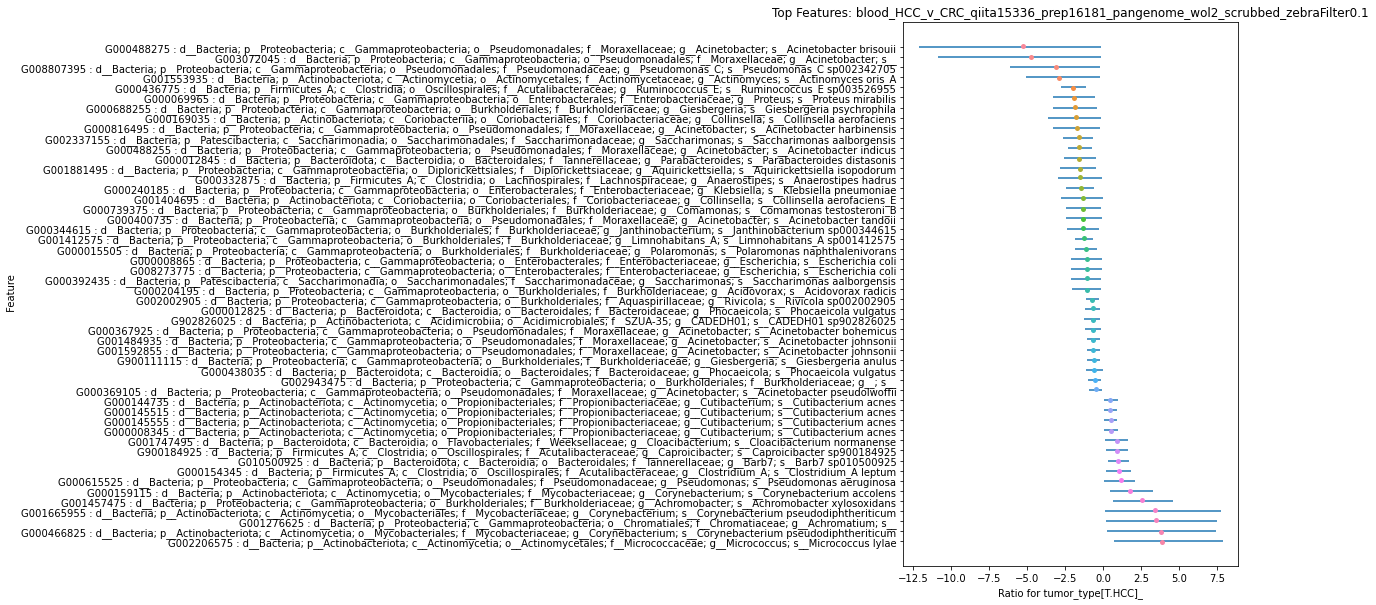

In [24]:
for k in data_dict.keys(): 
    for v in vars_to_check.keys(): 
        if v in k:
            print(var)
            xlab = 'Ratio for ' + var
            var = vars_to_check[v]
    
    ylab = ' Feature'
    df_for_display = data_dict[k].reset_index()
    df_for_display = df_for_display.loc[df_for_display.credible == 'yes']
    fig, ax = plt.subplots(figsize=(6, 10))

    add_taxonomy_col(df_for_display)

    display_top_n_feats(df_for_display, 25, 'gOTU_Taxonomy', var+'mean', xlab, ylab,
                            'Top Features: ' + k)